# **Vision Mamba : Efficient Visual Representation Learning with Bidirectional State Space Model**

https://arxiv.org/pdf/2401.09417.pdf

## **Introduction**

Mamba는 time-varying parameters를 SSM에 통합하고 hardware-aware algorithm으로 매우 효율적인 training/inference를 가능하게 함.  

이는 Mamba의 성능이 Transformer의 대안으로 유망한 것을 보여주지만 ViT처럼 image나 video와 같은 visual data를 다루는 pure-SSM-based backbone이 아직 존재하지 않음  

저자들의 main contributions :    
1. bidirectional SSM for data-dependent global visual context modeling and position embeddings for location-aware visual understanding을 통합하여 Vim 제안  
2. attention 없이 제안된 Vim은 ViT만큼의 modeling power를 가지지만 이차 시간 이하의 계산 및 선형 메모리 복잡도를 가짐
3. ImageNet classification and dense prediction downstream task을 시행 후 DeiT를 능가하는 성능을 달성

## **Method**

### **Preliminaries**

S4, Mamba와 같은 SSM-based model은 continuous system으로부터 영감을 받았음  

continuous system은 일반적으로 1-D function or sequence를 hidden state 를 통해 mapping하는 것을 말함  

$ x(t), y(t) ∈ ℝ,\space h(t) ∈ ℝ^N $  

$ A ∈ ℝ^{N × N}, B ∈ ℝ^{N × 1}, C ∈ ℝ^{1 × N} $에서  

$$\qquad\quad h'(t)  = Ah(t) + Bx(t) $$
$$ y(t) = Ch(t) $$  

S4, Mamba는 continuous system의 이산 버전으로 timescale parameter $Δ$를 통해 이산형 파라미터로 변환한다  

흔하게 사용되는 방법은 zero-order hold(ZOH)로 아래와 같이 변환함  

$$ \bar A = \exp(ΔA) $$
$$ \bar B = (ΔA)^{-1}(\exp(ΔA)-I)⋅Δ
B $$  

위와 같이 변환 후 global convolution으로 output을 계산할 수 있다.  

$h_t  = \bar Ah_{t-1} + Bx_t $  

$ y_t = Ch_t $  



$ \bar K = (C \bar{B}, C \bar{AB}, ..., C \bar{A}^{M-1}\bar{B}) $  
$𝐲 = 𝐱 * \bar{K}$

### **Vision Mamba**

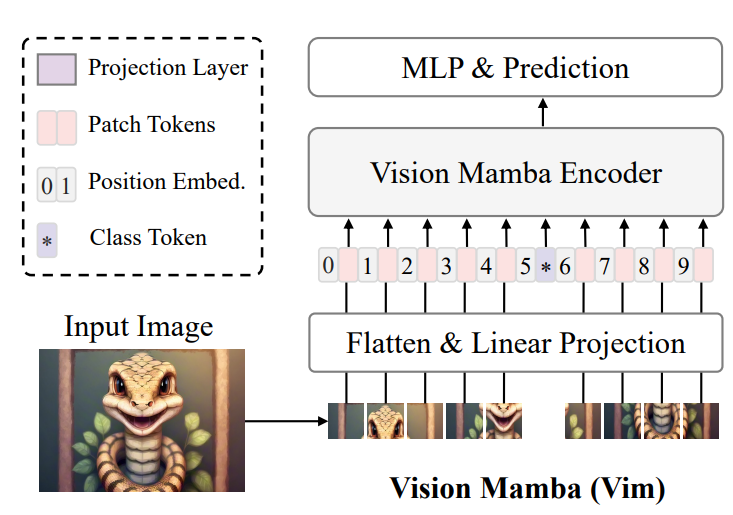

standard Mamba는 1-D sequence로 설계되있기 때문에 vision task를 진행하기 위해서 먼저 2-D image $t \in ℝ^{H × W × C}$를 flattened 2-D patches $x_p \in ℝ^{J ×(p^2 \cdot C)}$로 변환  

변환 후에 position embeddings $𝐄_{pos} \in ℝ^{(J+1)×D}$를 더해줌, 식으로 표현하면  

$$ 𝐓_0 = [t_{cls} ; t^1_pW ; t^2_pW ; … ; t^J_pW ] + 𝐄_{pos}$$  

이때 $W \in ℝ^{(p^2 \cdot C)×D}$는 learnable projection matrix  

ViT, BERT로부터 영감을 받아 class token을 사용한 아래와 같은 구조  

$$ 𝐓_l = VIM (𝐓_{l-1}) + 𝐓_{l-1} $$
$$ f = Norm(𝐓^0_L) $$
$$ p̂ = MLP(f) $$  



### **Vim Block**

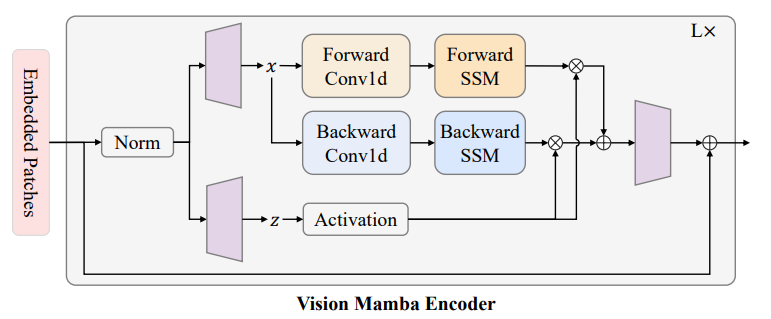

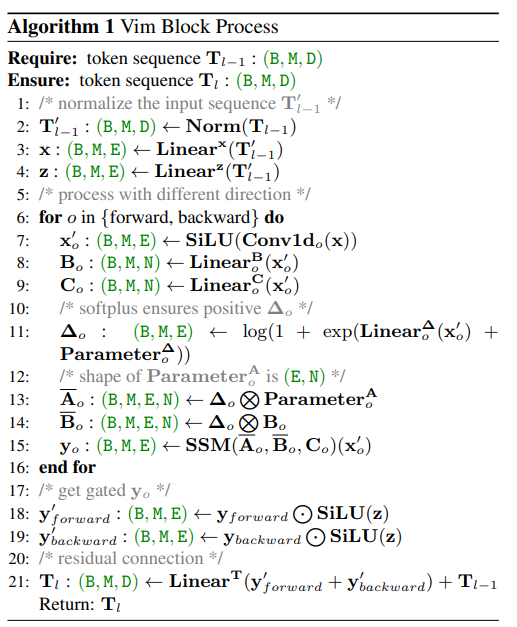

### **Efficiency Analysis**

**IO-Efficiency**

HBM과 SRAM은 GPU의 중요한 구성요소임. SRAM은 넓은 대역폭을 가지고 있고 더 빠름, HBM은 더 큰 메모리를 가지고 있고 더 느림  

HBM에서의 standard Vim의 SSM operation의 구현은 $ O(BMNE) $ 의 memory IO의 수를 필요로함  

먼저 $O(BMN+EN)$ bytes의 메모리$(Δ, A, B, C)$를 HBM에서 SRAM으로 불러온 후, SRAM에서 $(\bar{A}, \bar{B})$를 계산 후 SSM operation을 수행, 최종 output을 다시 HBM에 저장 함으로써 momory IO를 $O(BMEN)$에서 $O(BMN+EN)$로 줄일 수 있음

**Memory-Efficiency**

out-of-memory 문제를 피하고 long sequence에서 더 적은 메모리 사용을 위해 Vim은 Mamba와 같은 recomputation method를 사용함  

$(B,M,E,N)$ 크기의 중간 상태의 gradient를 계산 하는 경우 Vim은 backward pass에서 gradient를 다시 계산함(forward에서 cache로 저장하지 않는다는 뜻같음)  

activation이나 convolution의 output같은 중간 활성화값의 경우 많은 메모리를 차지하지만 빠르게 다시 계산할 수 있으므로 Vim에서는 GPU memory를 최적화 하기위해 recomputation method를 이용함



**Computation-Efficiency**

Vim block의 SSM과 Transformer의 self-attention은 global context 제공하는데 중요한 역할을 한다. 이 둘의 계산 복잡도는 각각  

$Ω(\mbox{self-attention}) = 4MD^2 + 2M^2D$  
$Ω(\mbox{SSM}) = 3M(2D)N + M(2D)N$  

으로 self-attention은 sequence length $M$에 대해 quadratic이지만 SSM인 linear임

## **Experiment**

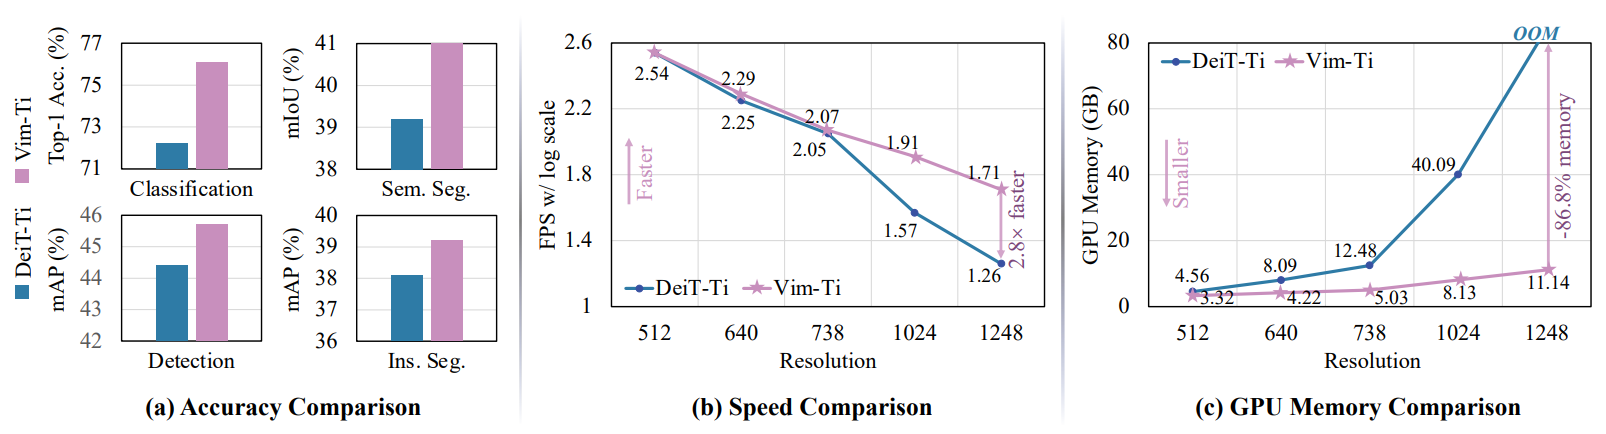

tiny-size Vim과 DeiT의 비교 결과, Vim이 속도와 메모리면에서 DeiT를 능가하는 성능을 보여줌.   

특히 512 x 512 size에서는 비슷하지만 1248 x 1248로 해상도를 늘렸을때 Vim은 DeiT보다 2.8배 빠르고 86.8% GPU memory를 절약할 수 있음

### **Image Classification**

**Setting**

ImageNet-1K : 1.28M training images and 50K validation images from 1000 categories  

fine-tune Vim with a long sequence setting 30 epochs after IN1K pretraining

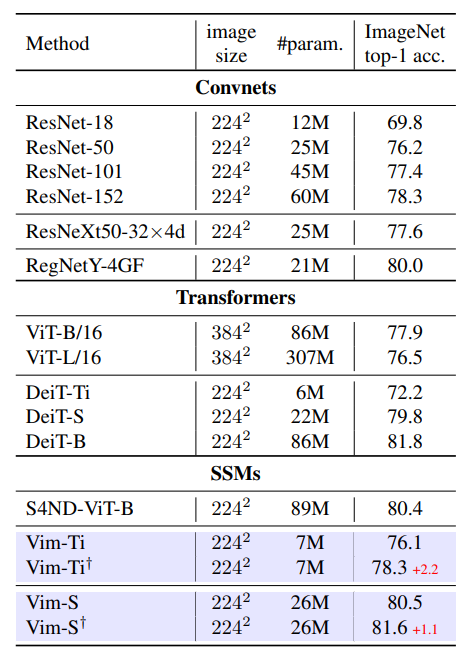

### **Semantic Segmentation**

**Setting**  

ADE20K dataset, UperNet 사용

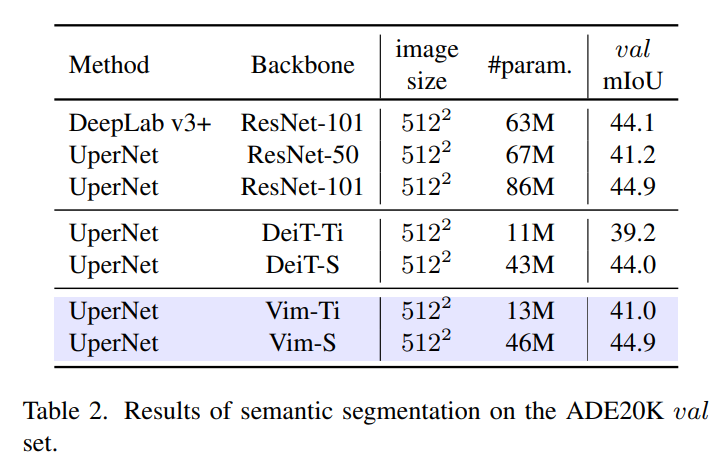

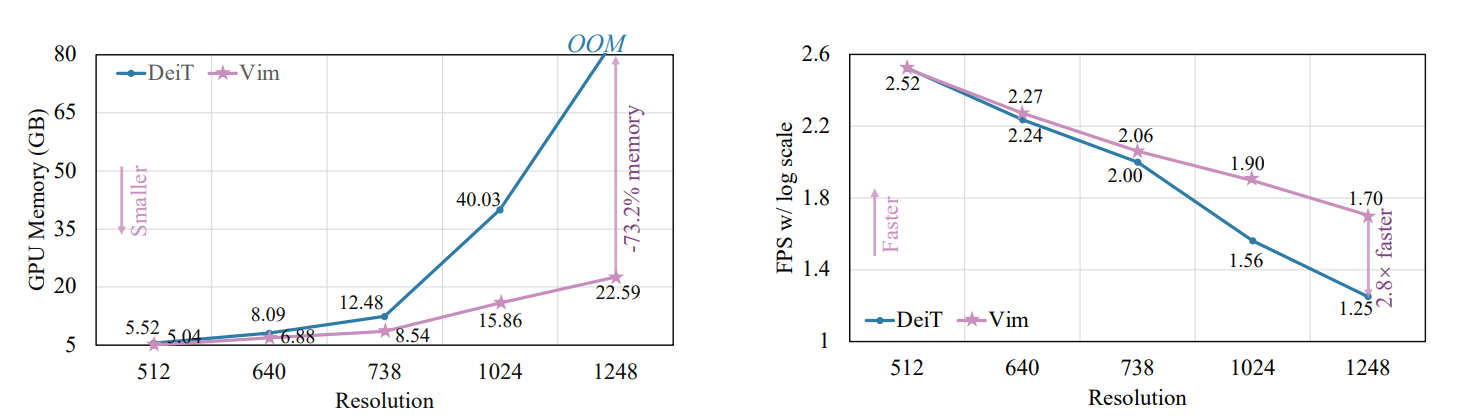

### **Object Detection & Instance Segmentaion**

**Setting**  

COCO 2017 dataset, ViTDet 사용

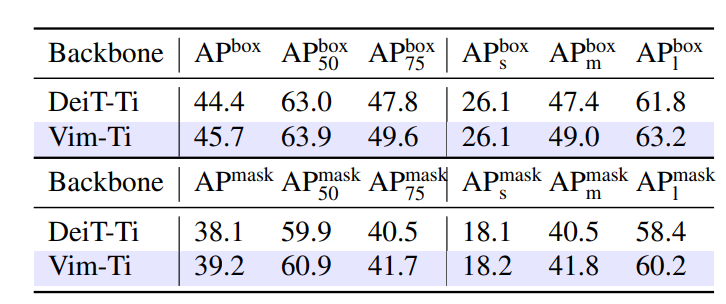

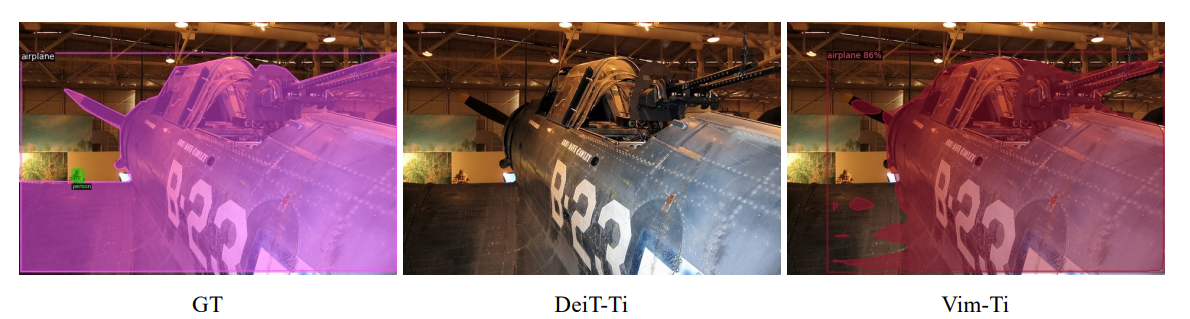

Cascade Mask R-CNN framwork에서 DeiT-Ti와 Vim-Ti를 시각화하여 비교한 결과  
long-range context learning 덕분에 DeiT에서 인식에 실패한 객체도 잡을 수 있음

## **Conclusion and Future Work**

일반적인 vision backbone으로 사용할 수 있는 Mamba는 이전 SSM for vision task와는 달리 visual representation을 sequence modeling manner로 학습함  

Transformer만큼이 성능과 더 적은 계산 복잡도를 가지고 ViT에 비해 상당히 적은 메모리와 시간을 소모하여 고해상도에도 적용가능  

unsupervised task, multimodal task등에 적합한지 추후 연구가 필요함